In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv("/content/fake_or_real_news.csv")
data.head()

,id,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [ ]:
data.drop(labels=['id','title'], axis='columns', inplace=True)

In [ ]:
texts=data["text"]
label = data["label"]

In [ ]:
texts.head()

0    Daniel Greenfield, a Shillman Journalism Fello...
1    Google Pinterest Digg Linkedin Reddit Stumbleu...
2    U.S. Secretary of State John F. Kerry said Mon...
3    — Kaydee King (@KaydeeKing) November 9, 2016 T...
4    It's primary day in New York and front-runners...
Name: text, dtype: object

# Data Preprocessing

In [ ]:
import re
def preprocess(text):
  text = text.lower()
  text = re.sub('[!#?,.:";()]'," ",text)
  return text

In [ ]:
texts=texts.apply(lambda x:preprocess(x))

In [ ]:
texts

0       daniel greenfield  a shillman journalism fello...
1       google pinterest digg linkedin reddit stumbleu...
2       u s  secretary of state john f  kerry said mon...
3       — kaydee king  @kaydeeking  november 9  2016 t...
4       it's primary day in new york and front-runners...
                              ...                        
6330    the state department told the republican natio...
6331    the ‘p’ in pbs should stand for ‘plutocratic’ ...
6332     anti-trump protesters are tools of the oligar...
6333    addis ababa  ethiopia —president obama convene...
6334    jeb bush is suddenly attacking trump  here's w...
Name: text, Length: 6335, dtype: object

In [ ]:
max_seq_len= 5000
max_num_words = 25000

# **Tokenize**

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [ ]:
tokenizer = Tokenizer(num_words=max_num_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
paded = pad_sequences(sequences,
                     maxlen=max_seq_len,
                     padding='pre',
                     truncating='pre')


In [ ]:
paded[0],label[0]

(array([  0,   0,   0, ..., 406, 810,  24], dtype=int32), 'FAKE')

In [ ]:
label =label.apply(lambda x: 0 if x == 'FAKE' else 1)

In [ ]:
paded[0],label[0]

(array([  0,   0,   0, ..., 406, 810,  24], dtype=int32), 0)

# Split

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(paded, label, test_size = 0.1)

# Model Creation

In [ ]:
from keras.models import Sequential
from keras.layers import Dense,Embedding, Conv1D,GlobalMaxPooling1D

In [ ]:
model = Sequential()
#word and sequence processing
model.add(Embedding(max_num_words,256,input_length=max_seq_len))
model.add(Conv1D(128,5,activation="relu"))
model.add(GlobalMaxPooling1D())
#classification
model.add(Dense(128,activation="relu"))
model.add(Dense(1,activation="sigmoid"))


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 5000, 256)         6400000   
                                                                 
 conv1d (Conv1D)             (None, 4996, 128)         163968    
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 6580609 (25.10 MB)
Trainable params: 6580609 (25.10 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [ ]:
history = model.fit(x_train,
                    y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_test, y_test))

Epoch 1/10
45/45 [==============================] - 29s 363ms/step - loss: 0.6171 - accuracy: 0.6871 - val_loss: 0.4672 - val_accuracy: 0.7981
Epoch 2/10
45/45 [==============================] - 14s 319ms/step - loss: 0.3086 - accuracy: 0.8812 - val_loss: 0.2426 - val_accuracy: 0.8927
Epoch 3/10
45/45 [==============================] - 15s 330ms/step - loss: 0.1568 - accuracy: 0.9463 - val_loss: 0.1972 - val_accuracy: 0.9085
Epoch 4/10
45/45 [==============================] - 15s 322ms/step - loss: 0.0796 - accuracy: 0.9774 - val_loss: 0.1269 - val_accuracy: 0.9543
Epoch 5/10
45/45 [==============================] - 14s 312ms/step - loss: 0.0325 - accuracy: 0.9947 - val_loss: 0.1202 - val_accuracy: 0.9479
Epoch 6/10
45/45 [==============================] - 14s 310ms/step - loss: 0.0116 - accuracy: 0.9993 - val_loss: 0.1644 - val_accuracy: 0.9369
Epoch 7/10
45/45 [==============================] - 14s 304ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.1120 - val_accuracy: 0.9527

# **Output**

In [ ]:
history.history.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

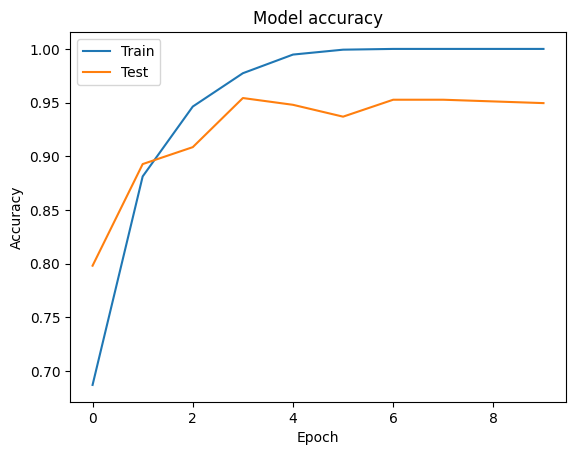

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
predictions = model.predict(x_test)
predictions

20/20 [==============================] - 1s 37ms/step


array([[2.75583945e-10],
       [9.99999762e-01],
       [1.41291723e-09],
       [9.99810755e-01],
       [1.74320940e-05],
       [2.68312372e-09],
       [9.99989033e-01],
       [9.99845147e-01],
       [9.99997973e-01],
       [2.11786784e-04],
       [9.99998689e-01],
       [1.63248251e-06],
       [9.99982953e-01],
       [1.20237942e-09],
       [9.99995232e-01],
       [9.99995828e-01],
       [5.72193031e-08],
       [9.99999404e-01],
       [4.98725325e-01],
       [2.62671057e-02],
       [9.99996424e-01],
       [9.99999881e-01],
       [9.99997973e-01],
       [9.99994993e-01],
       [9.99991655e-01],
       [9.99982715e-01],
       [7.93217020e-11],
       [2.08386405e-06],
       [3.01778357e-07],
       [8.74195655e-04],
       [1.91431241e-06],
       [9.99998450e-01],
       [1.23168356e-05],
       [9.99938846e-01],
       [2.51403360e-11],
       [1.00000000e+00],
       [9.99941111e-01],
       [4.74096123e-06],
       [6.81785468e-06],
       [1.00000000e+00],


In [ ]:
y_pred = [round(x[0]) for x in predictions]
y_pred

[0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,


In [ ]:
pd.DataFrame({"True Labels":y_test,"Predicted Label":y_pred})

,True Labels,Predicted Label
79,0,0
556,1,1
667,0,0
1773,1,1
397,0,0
...,...,...
619,1,1
1871,1,1
4498,0,0
3260,0,0
